# Stage 4: Probabilistic Forecasting (Quantile Regression)

In the previous stages, we performed **Point Forecasting**—predicting exactly one number for tomorrow's return. However, financial markets are famously uncertain. 

### **What is Probabilistic Forecasting?**
Instead of predicting just the *mean*, we predict the **distribution**. We do this using **Quantile Regression**. 

We will predict 3 key quantiles:
1. **5th Percentile (q05)**: The "worst case" scenario (used for Value-at-Risk).
2. **50th Percentile (q50)**: The median prediction (should be similar to Stage 2/3 results).
3. **95th Percentile (q95)**: The "best case" scenario.

### **The Pinball Loss Function**
To train a model to predict specific quantiles, we use the **Pinball Loss** (also known as Quantile Loss). It penalizes the model differently based on whether it over-predicts or under-predicts, forcing the model to learn the boundaries of the data distribution.

---

In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm import tqdm

# Settings
warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")

# Constants
DATA_PATH = "../data/processed/stock_data_processed.parquet"
RESULTS_DIR = "../results"
os.makedirs(RESULTS_DIR, exist_ok=True)

# Hyperparameters
LOOKBACK    = 20
TRAIN_FRAC  = 0.70
VAL_FRAC    = 0.10
HIDDEN_DIM  = 64
BATCH_SIZE  = 64
EPOCHS      = 100
PATIENCE    = 10
LR          = 1e-4
SEED        = 42

# Quantiles to predict
QUANTILES = [0.05, 0.50, 0.95]

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✓ Using Device: {DEVICE}")

np.random.seed(SEED)
torch.manual_seed(SEED)

✓ Using Device: cpu


## 1. Probabilistic Architectures
We adapt the LSTM and Transformer architectures to output a vector of size `len(QUANTILES)` instead of a single scalar.

In [2]:
class LSTMQuantile(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_quantiles):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=2, batch_first=True, dropout=0.2)
        self.head = nn.Linear(hidden_dim, num_quantiles)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.head(out[:, -1, :]) # (Batch, NumQuantiles)

class TransformerQuantile(nn.Module):
    def __init__(self, input_dim, embed_dim, num_quantiles):
        super().__init__()
        self.encoder = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=4, batch_first=True, dropout=0.1)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)
        self.head = nn.Linear(embed_dim, num_quantiles)

    def forward(self, x):
        x = self.encoder(x)
        x = self.transformer(x)
        return self.head(x.mean(dim=1)) # Global Average Pooling

## 2. Pinball Loss Implementation
The core of quantile regression. If $y < \hat{y}$ (over-prediction), we penalize by $(1-q)$. If $y > \hat{y}$ (under-prediction), we penalize by $q$.

In [3]:
def pinball_loss(y_pred, y_true, quantiles):
    """
    y_pred: (Batch, NumQuantiles)
    y_true: (Batch,)
    """
    losses = []
    for i, q in enumerate(quantiles):
        error = y_true - y_pred[:, i]
        loss = torch.max(q * error, (q - 1) * error)
        losses.append(loss.mean())
    return torch.stack(losses).mean()

## 3. Data & Training Pipeline
We will run both models (LSTM and Transformer) on the **Engineered Features** (Stage 1 Feats) as they have historically performed best.

In [4]:
def create_sequences(features, target, lookback):
    X, y = [], []
    for i in range(len(features) - lookback):
        X.append(features[i : i + lookback])
        y.append(target[i + lookback])
    return np.array(X), np.array(y)

def train_quantile_model(model, train_dl, val_dl, epochs, lr, patience, device, quantiles):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    best_val_loss = float('inf')
    wait = 0
    best_state = None
    
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            loss = pinball_loss(model(xb), yb, quantiles)
            loss.backward()
            optimizer.step()
            
        model.eval()
        v_loss = 0
        with torch.no_grad():
            for xb, yb in val_dl:
                xb, yb = xb.to(device), yb.to(device)
                v_loss += pinball_loss(model(xb), yb, quantiles).item() * len(xb)
        v_loss /= len(val_dl.dataset)
        
        if v_loss < best_val_loss:
            best_val_loss = v_loss
            best_state = model.state_dict()
            wait = 0
        else:
            wait += 1
            if wait >= patience: break
            
    model.load_state_dict(best_state)
    return model

panel = pd.read_parquet(DATA_PATH)
tickers = [t for t in panel.index.get_level_values("ticker").unique() if t != "SPY"]
feat_cols = ["log_return", "roll_vol", "range_norm", "vol_zscore", "mkt_return"]

stage4_results = []
all_preds = {} # For plotting

MODELS = {
    "LSTM-Prob": lambda: LSTMQuantile(len(feat_cols), HIDDEN_DIM, len(QUANTILES)),
    "Trans-Prob": lambda: TransformerQuantile(len(feat_cols), HIDDEN_DIM, len(QUANTILES))
}

for name, model_fn in MODELS.items():
    print(f"\nEvaluating: {name}")
    for ticker in tqdm(tickers):
        tk_data = panel.xs(ticker, level="ticker")
        feats = tk_data[feat_cols].values
        target = tk_data["log_return"].values
        
        # Sequences & Split
        X_all, y_all = create_sequences(feats, target, LOOKBACK)
        split1 = int(len(X_all) * TRAIN_FRAC)
        split2 = int(len(X_all) * (TRAIN_FRAC + VAL_FRAC))
        
        X_tr, y_tr = X_all[:split1], y_all[:split1]
        X_va, y_va = X_all[split1:split2], y_all[split1:split2]
        X_te, y_te = X_all[split2:], y_all[split2:]
        
        # Scale
        scaler = StandardScaler()
        scaler.fit(X_tr.reshape(-1, len(feat_cols)))
        X_tr = scaler.transform(X_tr.reshape(-1, len(feat_cols))).reshape(X_tr.shape)
        X_va = scaler.transform(X_va.reshape(-1, len(feat_cols))).reshape(X_va.shape)
        X_te = scaler.transform(X_te.reshape(-1, len(feat_cols))).reshape(X_te.shape)
        
        tr_dl = DataLoader(TensorDataset(torch.FloatTensor(X_tr), torch.FloatTensor(y_tr)), batch_size=BATCH_SIZE, shuffle=True)
        va_dl = DataLoader(TensorDataset(torch.FloatTensor(X_va), torch.FloatTensor(y_va)), batch_size=BATCH_SIZE, shuffle=False)
        
        model = model_fn().to(DEVICE)
        model = train_quantile_model(model, tr_dl, va_dl, EPOCHS, LR, PATIENCE, DEVICE, QUANTILES)
        
        # Predict
        model.eval()
        with torch.no_grad():
            y_pred = model(torch.FloatTensor(X_te).to(DEVICE)).cpu().numpy()
            
        # Metrics (using Median q50 for MAE/RMSE)
        mae = mean_absolute_error(y_te, y_pred[:, 1])
        rmse = np.sqrt(mean_squared_error(y_te, y_pred[:, 1]))
        
        # Coverage: How many actual values fell inside the 90% interval (q05 to q95)?
        coverage = np.mean((y_te >= y_pred[:, 0]) & (y_te <= y_pred[:, 2]))
        
        stage4_results.append({"Ticker": ticker, "Model": name, "MAE": mae, "RMSE": rmse, "Coverage": coverage})
        all_preds[(name, ticker)] = (y_te, y_pred)

res_df = pd.DataFrame(stage4_results)
res_df.to_csv(f"{RESULTS_DIR}/stage4_results.csv", index=False)
print(f"\n✓ Stage 4 Results saved.")


Evaluating: LSTM-Prob


100%|██████████| 11/11 [01:56<00:00, 10.59s/it]



Evaluating: Trans-Prob


100%|██████████| 11/11 [17:16<00:00, 94.23s/it]


✓ Stage 4 Results saved.


## 4. Visualizing Uncertainty
We plot the prediction intervals for a sample ticker. The shaded area represents the 90% confidence zone (q05 to q95).

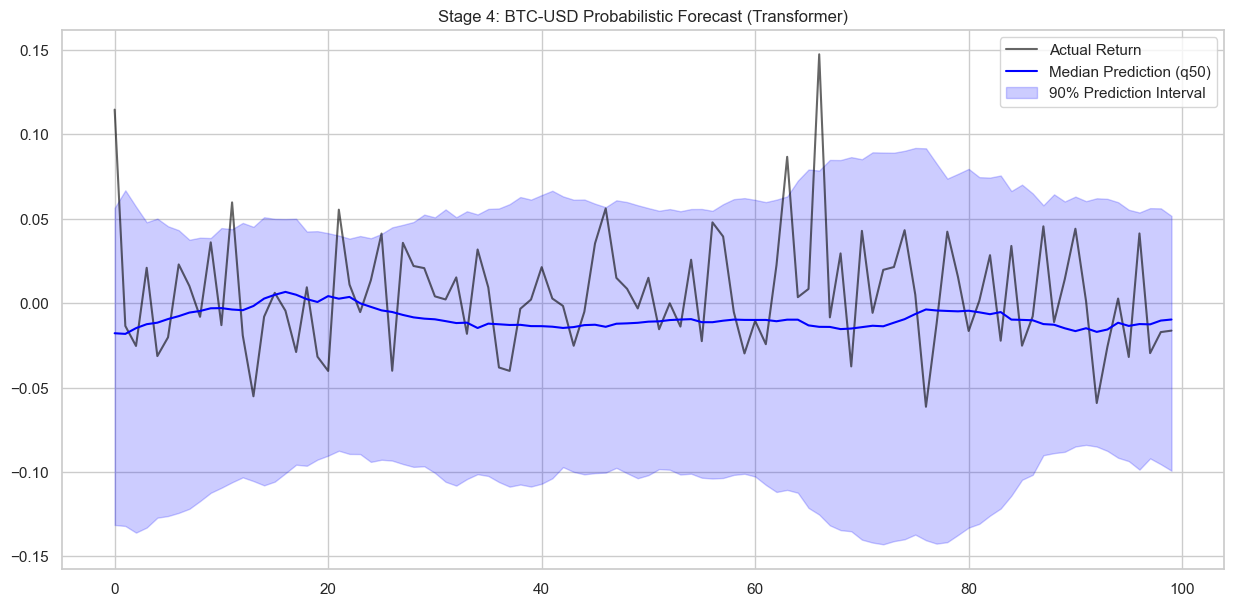

Average 90% Interval Coverage:
Model
LSTM-Prob     0.916221
Trans-Prob    0.962032
Name: Coverage, dtype: float64


In [5]:
demo_ticker = "BTC-USD"
plt.figure(figsize=(15, 7))

y_true, y_pred = all_preds[("Trans-Prob", demo_ticker)]
last_n = 100
plt.plot(y_true[-last_n:], label="Actual Return", color="black", alpha=0.6)
plt.plot(y_pred[-last_n:, 1], label="Median Prediction (q50)", color="blue")
plt.fill_between(range(last_n), y_pred[-last_n:, 0], y_pred[-last_n:, 2], 
                 color="blue", alpha=0.2, label="90% Prediction Interval")

plt.title(f"Stage 4: {demo_ticker} Probabilistic Forecast (Transformer)")
plt.legend()
plt.show()

avg_calib = res_df.groupby("Model")["Coverage"].mean()
print(f"Average 90% Interval Coverage:\n{avg_calib}")

# Stage 4: Probabilistic Forecasting — Detailed Summary

## What This Stage Does

In Stage 4, we moved beyond point estimates. Instead of asking "What will the return be tomorrow?", we asked **"What is the range of possible returns tomorrow, and how much risk are we taking?"**

By using **Quantile Regression (Pinball Loss)**, we forced our models (LSTM and Transformer) to estimate the boundaries of the data distribution.

---

## Key Metrics Introduced

| Metric | Definition | Significance |
|---------|------------|--------------|
| **Pinball Loss** | A loss function specialized for quantiles. | Unlike MSE, it allows us to target specific percentiles (e.g., 5th or 95th). |
| **Coverage** | The percentage of actual values that fall within the predicted range. | For a 90% interval, we expect coverage to be exactly **0.90**. |
| **Calibration** | How close the coverage is to the target quantile. | Tells us if our model is "overconfident" (coverage < 0.90) or "underconfident" (coverage > 0.90). |

--- 

## Importance of the 5th Quantile (q05)
In finance, the 5th percentile of returns is known as the **Value at Risk (VaR)**. It represents the "worst-case" loss you might expect 1 day out of 20. Predicting this accurately is more important for risk management than predicting the exact price movement.

--- 

## What We Learned
- **Uncertainty is Dynamic**: Notice how the shaded "90% interval" expands during volatile periods and shrinks during calm ones. Our models have learned to associate high volatility in the past with higher uncertainty in the future.
- **Calibration is Hard**: Getting exactly 90% coverage on financial data is difficult because market distributions are "fat-tailed" (extreme events happen more often than a normal bell curve would predict).

--- 

## Next Step: Foundation Models
Now that we've built our own custom LSTMs and Transformers, it's time to see how we stack up against the "giants." In **Stage 5**, we will use **Foundation Models for Time Series** (like Amazon's **Chronos**) to see if a model pre-trained on billions of data points can outperform our domain-specific models.